## INTRODUCTION : 

This notebook contains the main code used in the first part of the paper (GFP diffusion with one receptor, and no signaling). It is used to produce curves taking into account boosting of GFP fluorescence by Nb1^{high}.

## Part 1 : Simulations of gradient formation and figures : 

In [15]:
#import packages : 

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import CubicSpline
import pandas as pd
import numpy as np
import os
import sys 
import random
from scipy.optimize import minimize

##import experimental data  : 

dir='./Experimental_Data'

#import data from high affinity nanobody (VHH)  experiment
vhh=pd.read_csv(dir+'/hh-VHH-CD8.csv')
col = vhh.loc[: , "1":"11"]
vhh['signal_mean'] = col.mean(axis=1)
vhh['signal_std'] = col.std(axis=1)
vhh['signal_var'] = col.var(axis=1)


#import data from high affinity nanobody + fat body trap experiment

fat_body=pd.read_csv(dir+'/20190712 ptc-sGFP hh-VHH-CD8, lpp>VHH-CD8.csv')
col = fat_body.loc[: , "1":"7"]
fat_body['signal_mean'] = col.mean(axis=1)
fat_body['signal_std'] = col.std(axis=1)
fat_body['signal_var'] = col.var(axis=1)


#import data from high affinity nanobody overexpression  experiment

vhh_gal4=pd.read_csv(dir+'/20190709 ptc-sG hhG4 UAS-VHH-CD8_copy_pandas.csv')
col = vhh_gal4.loc[: , "sample1":"sample8"]
vhh_gal4['signal_mean'] = col.mean(axis=1)
vhh_gal4['signal_std'] = col.std(axis=1)
vhh_gal4['signal_var'] = col.var(axis=1)

#import data from low affinity nanobody experiment
lag3=pd.read_csv(dir+'/20190307 ptc-sG hh-LaG3-CD8.csv')
col = lag3.loc[: , "1":"10"]
lag3['signal_mean'] = col.mean(axis=1)
lag3['signal_std'] = col.std(axis=1)
lag3['signal_var'] = col.var(axis=1)



In [16]:
## Simulating gradient formation : 


#domain size (in um)
L = 116
#number of points within the domain
nb_x_points = 400
#array of values of x positions
x_array = np.linspace(-(1.0 - 1.0 / 2.0/ float(nb_x_points)) * L,
                      (1.0 - 1.0 / 2.0/ float(nb_x_points)) * L,
                      nb_x_points)
#spatial resolution
delta_x = x_array[1]-x_array[0]
#define a function that will return the time evolution of the concentration profile
def dcdt_function(c_array,
                  t,
                  J,
                  D,
                  h,
                  k_on,
                  k_off,
                  jr,
                  kappa_H,
                  source_size,
                  k_H):
    """Differential equations for the concentration equation, discretized in x,
    and for the evolution of the source concentration.
    c_array is the current concentration profile,
    t is the time point
    J is the influx from the source
    D is the diffusion constant
    h is the size of the intercellular space
    k_on is the on rate to receptors
    k_off is the off rate from receptors
    jr is the product of k, the effective degradation rate,
    and nT, the total density of receptors
    kappa_H is the exchange rate between tissue and hemolymph
    source_size is the length of the source
    k_H is the degradation rate in the hemolymph
    """
    #cH is the concentration in the hemolymph
    #here always assumed to be at equilibrium
    cH = kappa_H * np.mean(c_array)/(kappa_H + k_H)
    #define a spline; imposing boundary conditions on the first derivative
    #on the left the derivative is imposed to vanish
    #on the right the derivative is imposed to vanish
    c_spline = CubicSpline(x_array, c_array, bc_type = ((1, 0.0), (1, 0.0)))
    #compute the x derivatives with a spline
    cxx=c_spline(x_array, 2)
    # Use masks to do a different calculation within the source and outside
    mask_source = (x_array >=-source_size) &(x_array <=0)
    #posterior = where the receptors are expressed
    mask_tissue_posterior = x_array > 0
    # anterior = no receptors
    mask_tissue_anterior = x_array < -source_size
    # Compute dc/dt, the change of concentration
    dcdt_vector = np.zeros(len(x_array))
    dcdt_vector[mask_source] = (D * cxx[mask_source]
                                + J
                                - kappa_H * (c_array[mask_source] - cH))
    dcdt_vector[mask_tissue_posterior] =  (D * cxx[mask_tissue_posterior]
                                          - 1.0 / h * k_on * jr *c_array[mask_tissue_posterior] 
                                          /(k_off + k_on * c_array[mask_tissue_posterior])
                                          - kappa_H * (c_array[mask_tissue_posterior] - cH))
    dcdt_vector[mask_tissue_anterior] =  (D * cxx[mask_tissue_anterior]
                                          - kappa_H * (c_array[mask_tissue_anterior] - cH))
    #return the vector dc/dt 
    return dcdt_vector

In [17]:
#Set parameters :  
#diffusion constant in um/s^2
D_value = 21 
#size of intercellular space in um
h_value = 0.02 
# on rate for the high affinity nanobody, in /nM/s
k_on_value = 7.7 * 10 **(-4) 
# off rate for the high affinity nanobody, in /s
k_off_value = 1.7 * 10 ** (-4) 
# on rate for the low affinity nanobody,in /nM/s
k_on_value_LAG3 = 2 * 10 ** (-3) 
# off rate for the low affinity nanobody, in /s
k_off_value_LAG3 = 5 * 10 ** (-2) 
# Length of the source, in microns
source_size_value = 26. 
#normalized receptor density
nT_value=1 

In [18]:
def predicted_bound_GFP_function(x_data,
                                 c_data,
                                 J,
                                 D,
                                 h,
                                 k_on,
                                 k_off,
                                 jr,
                                 kappa_H,
                                 source_size,
                                 k_H,
                                 precision):
    #"precision" stops the simulation if a steady state has been reached
    time_0 = 500
    nb_time_points = 20
    pseudo_time_array = np.linspace(0, time_0, nb_time_points)
    initial_condition = np.zeros(len(x_array))
    # calculate the profile of free GFP
    sol = odeint(dcdt_function,
                 initial_condition,
                 pseudo_time_array,
                 args=(J, D, h, k_on, k_off, jr, kappa_H, source_size, k_H)
                 )
    sol1=sol[-1, :]
    sol2=sol[-2, :]
    j=0
    while np.mean(np.square(sol1/sol2-1))>precision : 
        j+=1
        pseudo_time_array = np.linspace((j-1)*time_0, j*time_0, nb_time_points)
        sol = odeint(dcdt_function,
                 sol1,
                 pseudo_time_array,
                 args=(J, D, h, k_on, k_off, jr, kappa_H, source_size, k_H)
                 )
        sol1=sol[-1, :]
        sol2=sol[-2, :]
        if j>60 : 
            print("no steady state")
            sol1=sol2
    final_sol_free_GFP = sol[-1, :]
    #posterior = where the receptors are expressed
    mask_tissue_posterior = x_array > 0
    final_sol_bound_GFP=np.zeros_like(final_sol_free_GFP)
    # from the profile of free GFP, calculate the profile of bound GFP
    final_sol_bound_GFP[mask_tissue_posterior] = (k_on * nT_value * final_sol_free_GFP[mask_tissue_posterior]
                            /(k_off + k_on * final_sol_free_GFP[mask_tissue_posterior]))
    
    #The global variable nT is just a scaling factor. By setting it to 1, this function returns the normalized 
    #profile of bound receptors nb/nT. For special cases where the total number of receptors varies we change nT.
    
    #offset by delta_x
    #the delta_x ensures that one starts immediately after the end of the source
    predicted_bound_GFP = np.interp(x_data, x_array-delta_x, final_sol_bound_GFP)
    return predicted_bound_GFP

## Part 1 : Fitting the parameters taking boosting in account

In [8]:
boost_factor=1.5 
# if GFP-Nb-high fluorescence 1.5 more than GFP-Nb-low,
#we need to increase the NB-low concentration by 1.5 to compensate
# We first define the function that we minimize during the fit  : 
def curve_fit_function_minimization_boosting(x_data_vhh,
                                             c_data_vhh,
                                             x_data_fat_body,
                                             c_data_fat_body,
                                             x_data_lag3,
                                             c_data_lag3,
                                             J, D, h,
                                             k_on,
                                             k_off,
                                             k_on_lag3,
                                             k_off_lag3,
                                             jr,
                                             kappa_H,
                                             source_size,
                                             k_H,
                                             k_H_fat_body):
    predicted_bound_GFP_vhh =\
    predicted_bound_GFP_function(x_data_vhh,
                                 c_data_vhh['signal_mean'][7:211],
                                 J, 
                                 D,
                                 h,
                                 k_on,
                                 k_off,
                                 jr,
                                 kappa_H,
                                 source_size,
                                 k_H,
                                 precision)
    predicted_bound_GFP_fat_body =\
    predicted_bound_GFP_function(x_data_fat_body,
                                 c_data_fat_body['signal_mean'][7:211],
                                 J, 
                                 D,
                                 h,
                                 k_on,
                                 k_off,
                                 jr,
                                 kappa_H,
                                 source_size,
                                 k_H_fat_body,
                                 precision)
    predicted_bound_GFP_lag3 =\
    predicted_bound_GFP_function(x_data_lag3,
                                 c_data_lag3['signal_mean'][7:211],
                                 J, 
                                 D,
                                 h,
                                 k_on_lag3,
                                 k_off_lag3,
                                 jr,
                                 kappa_H,
                                 source_size,
                                 k_H,
                                 precision)
    #calculate the mean of the vhh experiment 
    #this is used to compare different curves
    sim_mean = np.mean(predicted_bound_GFP_vhh)
    exp_mean = np.mean(vhh['signal_mean'][7:211])
    #calculate differences for each individual experimental curves (10 vor vhh, 6 for the fat body trap, and 9 for lag3)
    diff_vhh=[];diff_lag3=[];diff_fat_body=[];
    for i in range(11):
        if i!=4 : 
            diff_vhh.append(predicted_bound_GFP_vhh / sim_mean - c_data_vhh[str(i+1)][7:211]/exp_mean)
        else : #special case as this one curve has data on a shorter total length
            diff_vhh.append(predicted_bound_GFP_vhh[:183] / sim_mean - c_data_vhh[str(i+1)][7:190]/exp_mean)
    
    for i in range (7) :
        diff_fat_body.append( (predicted_bound_GFP_fat_body / sim_mean - c_data_fat_body[str(i+1)][7:211] / exp_mean))
    
    for i in range (10) :
        diff_lag3.append(predicted_bound_GFP_lag3/ sim_mean - c_data_lag3[str(i+1)][7:211]*boost_factor/ exp_mean)
        
    #sum the squares of differences
    diff_vhh=[item for sublist in diff_vhh for item in sublist]
    diff_lag3=[item for sublist in diff_lag3 for item in sublist]
    diff_fat_body=[item for sublist in diff_fat_body for item in sublist]
    diff_tot=np.concatenate((diff_vhh,diff_lag3,diff_fat_body))
    print('Energy',np.sum(np.square(diff_tot)))
    print(J, kappa_H, k_H, k_H_fat_body, jr)
    return np.sum(np.square(diff_tot)) 

In [10]:
#initial conditions for the minimization process: format [J,kappa,kh,kh,jr]
precision =1e-12
IC=np.array([0.30434832, 0.07535886, 0.00998797, 0.19439367, 0.00262643]) 
#warning : that minimization step can be rather long (1 hour)
res = minimize(lambda x: curve_fit_function_minimization_boosting(vhh['distance'][7:211]-vhh['distance'][7],vhh
                                                          ,fat_body['distance'][7:211]-fat_body['distance'][7],
                                                          fat_body,
                                                          lag3['distance'][7:211]-lag3['distance'][7],
                                                          lag3,
                                                          x[0],
                                                          D_value,
                                                          h_value,
                                                          k_on_value,
                                                          k_off_value,
                                                          k_on_value_LAG3,
                                                          k_off_value_LAG3,
                                                          x[4],
                                                          x[1],
                                                          source_size_value,
                                                          x[2],
                                                          x[3]),
                                                          IC,
                                                          method = 'Nelder-Mead',
                                                          tol=1.0e-5)

    
result=np.concatenate((IC,res.x,[res.fun]))
print(res.x)


Energy 67.03843120596935
0.30434832 0.07535886 0.00998797 0.19439367 0.00262643
Energy 70.49715032250529
0.31956573600000004 0.07535886 0.00998797 0.19439367 0.00262643
Energy 69.20619136224124
0.30434832 0.07912680300000001 0.00998797 0.19439367 0.00262643
Energy 69.10416366978725
0.30434832 0.07535886 0.010487368500000002 0.19439367 0.00262643
Energy 67.15370564755517
0.30434832 0.07535886 0.00998797 0.2041133535 0.00262643
Energy 63.952545480461936
0.30434832 0.07535886 0.00998797 0.19439367 0.0027577515
Energy 68.33339380358285
0.28913090399999997 0.07686603720000001 0.010187729400000003 0.19828154339999995 0.0026789585999999997
Energy 66.88835314338586
0.29826135359999995 0.07219378788000001 0.010267633160000003 0.19983669275999996 0.00269997004
Energy 63.783321737003405
0.29582656704 0.07469570203200002 0.009680340524 0.202013901864 0.002729386056
Energy 63.19188863866825
0.2915656905599999 0.07436412304800002 0.009276826536 0.20582401779599996 0.0027808640840000006
Energy 61.901

Energy 42.35719882001666
0.35802140991733356 0.07345934558059244 0.005977707501102471 0.17663766679947168 0.0033165340468897615
Energy 42.42308218476965
0.3607084394298392 0.07545130406864348 0.006023322780224244 0.16573727447726117 0.0033624571830819915
Energy 42.490980793159835
0.3566653169895554 0.07404716346374085 0.006246994877582807 0.17516250159282 0.003284042360036603
Energy 42.27937375857958
0.3641463533514706 0.07258336765229648 0.006177265641421962 0.1738194161778034 0.0033166878333779556
Energy 42.30975368450546
0.37109934268166933 0.07270487937913453 0.006305640648640309 0.16620361308218068 0.0033482069696952575
Energy 42.20031412494585
0.3613479741480087 0.07261996760293082 0.0062624619965257105 0.17235414492861975 0.003307978656099881
Energy 42.18389552036666
0.36391578435232597 0.07273813307978744 0.006427183877484885 0.16565833878958908 0.0033230273158024607
Energy 42.399244531189794
0.35792677901928194 0.07405749493550343 0.006443204943276119 0.16818074846205353 0.003

Energy 41.90131920397853
0.3711813599664255 0.0721472715443402 0.006189172598054711 0.15736839717713527 0.003405160795599398
Energy 41.9025078667322
0.37092667058854517 0.07224561319077066 0.006153176420755116 0.15795497364585273 0.003405487444069066
Energy 41.9013659792808
0.37095148268701605 0.07224015439070476 0.006166120713909549 0.1576985491135623 0.0034055553197535203
Energy 41.90325771178621
0.37122206886308984 0.07238359614455861 0.006173907277917991 0.15704848915532285 0.003404822014412949
Energy 41.901278824874254
0.3709007567422137 0.07219332231810448 0.006177764866858314 0.15760953995989097 0.003405837559512742
Energy 41.90377097914571
0.3702667349359148 0.07213276433448995 0.006162372540513935 0.15930624453119974 0.003400236476776934
Energy 41.90119485652025
0.371196660158612 0.07227857953715655 0.0061807849640494504 0.15692439193788554 0.0034070751741873324
Energy 41.90134371004611
0.3712233453470104 0.07205771183705105 0.006181586056436582 0.15748771007989532 0.003404832

Energy 41.89359224783179
0.3683139604679304 0.07187656814335708 0.006109947112837171 0.1564381376940252 0.003389263207147465
Energy 41.89337681830414
0.3688923099574324 0.07184063576161401 0.006134775729583248 0.15646060845443238 0.003389567360244485
Energy 41.89336707250187
0.3688259936182634 0.07178084047738373 0.00614184298028975 0.15621271395421354 0.003386760186064954
Energy 41.89142517217516
0.3681639261285895 0.07177957630606102 0.0061312331997644826 0.1566865741222888 0.00338388721168375
Energy 41.890001682127846
0.3675017020814848 0.07169307089602686 0.006132235174609257 0.15673860498032643 0.003377414413386246
Energy 41.89174409555311
0.36714402650863953 0.07154575464435509 0.00611893936033266 0.15580947349944646 0.0033764271567618452
Energy 41.889584990019806
0.36705844809788835 0.07152685707924167 0.006111755824762118 0.15687881392174857 0.0033728336848740104
Energy 41.88960814659615
0.366090371306212 0.07133219471624933 0.006098480637414732 0.15727962813016022 0.0033625442

Energy 41.81192701684578
0.31531440971198244 0.06867291337545148 0.005366873212928804 0.1514647167631265 0.00298930123333253
Energy 41.80608887851936
0.32594534351706683 0.06923851059086991 0.0055161154855630345 0.15107276370353262 0.0030722227725770435
Energy 41.80326155331445
0.32175048746296797 0.06898300874013584 0.0054555364042891364 0.14973530374416427 0.003039357343740592
Energy 41.803389220871445
0.32068607127495097 0.0688986731574634 0.005439145351919658 0.14849558733623097 0.0030309301997961374
Energy 41.806600896095944
0.3285505970932173 0.06955899130394552 0.005536444641415214 0.15112229325887244 0.003090821193131528
Energy 41.80493954753278
0.32601641303311657 0.06934226148469581 0.005507623629921708 0.15097062504111655 0.0030717749519441465
Energy 41.80293138653485
0.3227085217129604 0.0689334244146417 0.005461907579656792 0.15102493323149507 0.0030450128863209443
Energy 41.802701884947396
0.3216833177671843 0.0687377996540594 0.005443308830496511 0.1511798175502166 0.003

Energy 41.79938648623461
0.3181838223458473 0.06852254749691969 0.005368458922565112 0.14884115563247385 0.003010554670484512
Energy 41.799325636800205
0.3183827638470573 0.06856327748095888 0.005369540857040266 0.14901063664417055 0.003011773651719392
Energy 41.799350399257875
0.31790380806099017 0.06853608369999754 0.005363032809304637 0.14878322365910537 0.0030080215883509284
Energy 41.79932626727536
0.3184485578212157 0.06855650070979097 0.005371013894080747 0.14901508285001178 0.003012410319383639
Energy 41.79934331028177
0.3190559379177072 0.0686000358493173 0.005378608147239842 0.14903371603292348 0.0030168355890462465
Energy 41.79934265719775
0.3184155552054232 0.06856255490724142 0.005373104258340693 0.1491045879407965 0.0030118772747368067
Energy 41.79937071237443
0.3176877985790815 0.06851408173662572 0.005362820311808028 0.14898063409989065 0.0030065241388877667
Energy 41.79932395743802
0.3187139030830508 0.0685785473211444 0.005374661188381888 0.14902044554966526 0.0030142

Energy 41.79930507206895
0.318283910484621 0.06852993526097753 0.005367739257936349 0.14897750908621737 0.003010746882744368
Energy 41.79930499062282
0.3182714587258501 0.0685295389661609 0.005367576114824844 0.14897947227230013 0.003010656609854562
Energy 41.79930513436282
0.31823238689205813 0.06852650261536392 0.00536680578265917 0.14896890825696518 0.0030103825279299504
Energy 41.79930496901387
0.3182692809368219 0.06852998189337081 0.005367621413538423 0.1489845939760559 0.003010638198022517
Energy 41.79930519883678
0.3182314367641754 0.06852646576997865 0.0053666888170190025 0.14897030291508345 0.0030103487957184693
Energy 41.79930493959505
0.3182669171130195 0.0685297439007661 0.005367596572944238 0.14898307509380135 0.003010629573647757
Energy 41.799305200404795
0.3183057104893595 0.06853219200946277 0.005368091579102498 0.14899570709105842 0.0030109336752815125
Energy 41.79930496578602
0.31824316173804945 0.06852787368014297 0.00536713094406858 0.14897490445932865 0.0030104424

In [19]:
#Plot of the experimental data with boosting parameters : 
#influx from the source in nM/s
J_value_boost = 0.32 
#exchange rate between tissue and hemolymph, in /s
kappa_H_value_boost = 0.069 
#effective degradation rate in the haemolymph
k_H_value_boost = 0.0054 
#effective degradation rate in the haemolymph in the fat body trap experiment
k_H_fat_body_value_boost=0.15
#product of degradation rate and receptor density in nM.um/s
jr_value_boost = 3.0e-3
precision=1e-12
nT_value = 1
#simulate the vhh experiment 
result_vhh = predicted_bound_GFP_function(vhh['distance'][7:]-vhh['distance'][7],
                                          vhh['signal_mean'][7:],
                                          J_value_boost,
                                          D_value,
                                          h_value,
                                          k_on_value,
                                          k_off_value,
                                          jr_value_boost,
                                          kappa_H_value_boost,
                                          source_size_value,
                                          k_H_value_boost,precision) 
#simulate fat body experiment 
result_fat_body = predicted_bound_GFP_function(fat_body['distance'][7:299]-fat_body['distance'][7],
                                               fat_body['signal_mean'][7:299],
                                          J_value_boost,
                                          D_value,
                                          h_value,
                                          k_on_value,
                                          k_off_value,
                                          jr_value_boost,
                                          kappa_H_value_boost,
                                          source_size_value,
                                          k_H_fat_body_value_boost,precision)

#simulate experiment where the nanobody is now lag3
result_lag3 = predicted_bound_GFP_function(lag3['distance'][7:295]-lag3['distance'][7],
                                           lag3['signal_mean'][7:295],
                                           J_value_boost,
                                           D_value,
                                           h_value,
                                           k_on_value_LAG3,
                                           k_off_value_LAG3,
                                           jr_value_boost,
                                          kappa_H_value_boost,
                                          source_size_value,
                                          k_H_value_boost,precision)
#simulating an increase of receptors 
nT_value = 20*nT_value #In "the wall" the production and consequently the number of receptors is increased by approx. 20 fold:
result_wall=predicted_bound_GFP_function(vhh_gal4['distance'][7:295]-vhh_gal4['distance'][7],
                                          vhh_gal4['signal_mean'][7:295],
                                          J_value_boost,
                                          D_value,
                                          h_value,
                                          k_on_value,
                                          k_off_value,
                                          20*jr_value_boost,
                                          kappa_H_value_boost,
                                          source_size_value,
                                          k_H_value_boost,precision)


### Figure S4-B : 

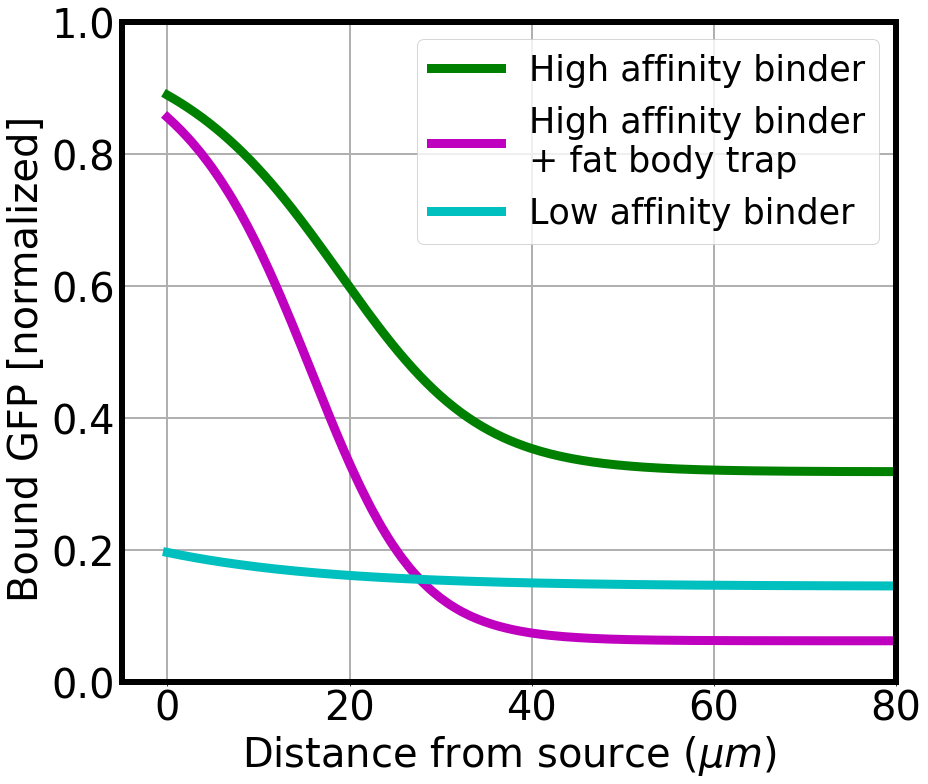

In [20]:
f=plt.figure(figsize = (13,11))
ax1 = plt.subplot(111)
ax1.plot(vhh['distance'][7:]-vhh['distance'][7],
         result_vhh,
         label = "Bound GFP",
         lw=9,
         ms = 10,
         color = "g")
ax1.plot(fat_body['distance'][7:299]-fat_body['distance'][7],
         result_fat_body,
         label = "Bound GFP",
         lw=9,
         ms = 10,
         color = "m")
ax1.plot(lag3['distance'][7:295]-lag3['distance'][7],
         result_lag3,
         label = "Bound GFP",
         lw=9,
         ms = 10,
         color = "c")
y1min= 0
y1max=1
ax1.set_xlim(-5,80)
ax1.set_ylim(y1min,y1max)
plt.tick_params(labelsize=40)

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(6)

plt.ylabel(r"Bound GFP [normalized] ",fontsize =40)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =40)
plt.legend(['High affinity binder',
            'High affinity binder\n+ fat body trap',
            'Low affinity binder' ],
           fontsize=35)
plt.grid(lw=2)
plt.tight_layout()
plt.savefig('./Figures/Fig-S4-B.eps',format='eps',dpi=600)


## Figure S4-D :  Effect of increasing the number of receptors :


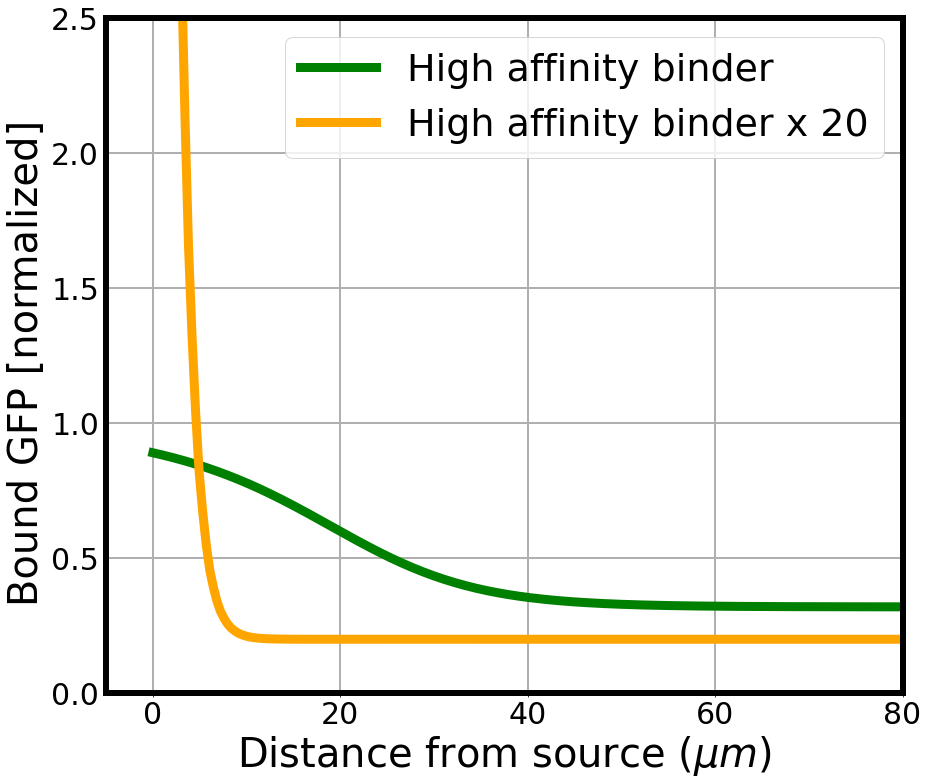

In [23]:
f2=plt.figure(figsize = (13,11))
ax2 = plt.subplot(111)
ax2.plot(vhh['distance'][7:]-vhh['distance'][7],
         result_vhh,
         lw=9,
         ms = 10,
         color = "g")
ax2.plot(vhh_gal4['distance'][7:295]-vhh_gal4['distance'][7],
         result_wall,
         lw=9,
         ms = 10,
         color='orange')
y2min= 0
y2max=2.5
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(6)
ax2.set_xlim(-5,80)
ax2.set_ylim(y2min,y2max)
plt.ylabel(r"Bound GFP [normalized] ",fontsize =40)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =40)
plt.tick_params(labelsize=30)
plt.legend([r'High affinity binder',
            r'High affinity binder x 20'],
           fontsize=38)
plt.grid(lw=2)
plt.tight_layout()
plt.savefig('./Figures/Fig-S4-D.eps',format='eps',dpi=600)


## Figure S4-F Effect of changing strength of the source : 


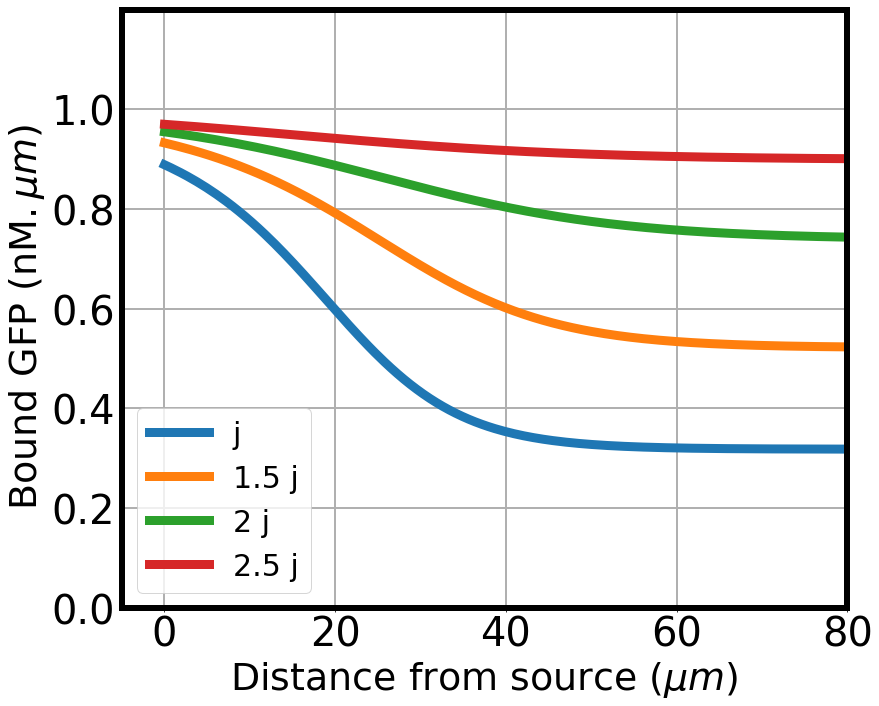

In [26]:
nT_value = 1
plt.figure(figsize = (13,11))
leg=[]
for jp in [J_value_boost,1.5*J_value_boost,2*J_value_boost,2.5*J_value_boost] : 
    result = predicted_bound_GFP_function(vhh['distance'][7:]-vhh['distance'][7],
                                          vhh['signal_mean'][7:],
                                          jp,
                                          D_value,
                                          h_value,
                                          k_on_value,
                                          k_off_value,
                                          jr_value_boost,
                                          kappa_H_value_boost,
                                          source_size_value,
                                          k_H_value_boost,precision)
    plt.plot(vhh['distance'][7:]-vhh['distance'][7],result, label = "Bound GFP",  lw=9,ms = 10)
    leg.append("j="+str(jp))
plt.ylabel(r"Bound GFP (nM$.\mu m$)  ",fontsize =38)
plt.xlabel(r"Distance from source $(\mu m) $",fontsize =38)
plt.tick_params(labelsize=30)
plt.grid(lw=2)  
plt.legend(['j',r'1.5 j',r'2 j',r'2.5 j'],prop={'size': 30})
plt.ylim(0,1.2)
plt.xlim(-5,80)
plt.yticks([0, 0.2,0.4,0.6,0.8,1.0])
plt.tick_params(labelsize=40)
ax2=plt.gca()
for axis in ['top','bottom','left','right']:
  ax2.spines[axis].set_linewidth(6)
plt.savefig('./Figures/Fig-S4-F.eps',format='eps',dpi=600)